In [139]:
import pandas as pd
from plotnine import *
import numpy as np
from sklearn.linear_model import LinearRegression
from numpy import polyfit

In [2]:
or_events = pd.read_parquet('./outage_report_2019-20')

In [134]:
filtered_or_events = or_events[(or_events['vendor'] != '') & (or_events['vendor'] != 'overview')].reset_index(drop=True)

In [135]:
filtered_or_events['evtime'] = pd.to_datetime(filtered_or_events['event_time'], unit='s')

In [136]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Apple-servers', 'Facebook-messenger', 'Youtube'], ['Apple', 'FB Msgr', 'YouTube'])

filtered_or_events['vendor_proper'] = proper_vendor_names(filtered_or_events['vendor'])

vendor_list = list(filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'}).sort_values('count')['vendor_proper'])

filtered_or_events['vendor_cat'] = pd.Categorical(filtered_or_events['vendor_proper'], ordered=True, categories=vendor_list)

In [45]:
facebook_reports = filtered_or_events[filtered_or_events['vendor'] == 'facebook'].reset_index(drop=True)

In [46]:
sorted_facebook_reports = facebook_reports.sort_values('event_time').reset_index(drop=True).set_index('evtime').resample('W')

In [182]:
sorted_facebook_reports = facebook_reports.sort_values('event_time').reset_index(drop=True).set_index('evtime').resample('M').sum().reset_index()

In [9]:
# That 20 minutes!
sorted_facebook_reports.loc[2, 'event_time'] - sorted_facebook_reports.loc[1, 'event_time']

1200.0

In [183]:
model = LinearRegression()
zeroed_time = (sorted_facebook_reports['event_time'] - sorted_facebook_reports.loc[0, 'event_time']).values.reshape(-1, 1)
model.fit(zeroed_time, sorted_facebook_reports['status_code'].values)
# calculate trend
trend = model.predict(zeroed_time)
trend[trend < 1] = 0
sorted_facebook_reports['trend'] = trend

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./plots/week_facebook_fit_trend.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


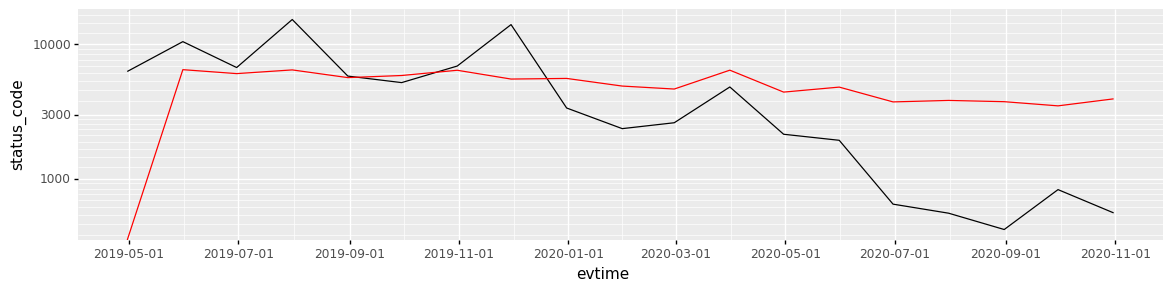

<ggplot: (340918032)>

In [184]:
# Trend
plt = ggplot(sorted_facebook_reports) +\
    geom_line(aes(x='evtime', y='status_code')) +\
    geom_line(aes(x='evtime', y='trend'), color='red') +\
    scale_y_log10() +\
    theme(figure_size=(14, 3))
    
plt.save('./plots/week_facebook_fit_trend.pdf', limitsize=False)
plt

In [118]:
sorted_facebook_reports['detrended'] = sorted_facebook_reports['status_code'] - sorted_facebook_reports['trend']
sorted_facebook_reports.loc[sorted_facebook_reports['detrended'] < 1, 'detrended'] = 0

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./plots/facebook_detrended_see_season.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


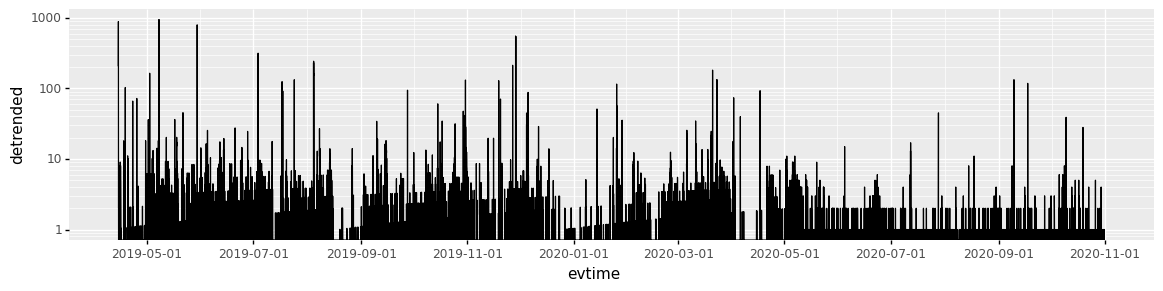

<ggplot: (378200962)>

In [119]:
# Seasonal
plt = ggplot(sorted_facebook_reports) +\
    geom_line(aes(x='evtime', y='detrended')) +\
    scale_y_log10() +\
    theme(figure_size=(14, 3))

plt.save('./plots/facebook_detrended_see_season.pdf', limitsize=False)
plt

In [120]:
pre_covid = sorted_facebook_reports[sorted_facebook_reports['evtime'] < '2020-05-01'].reset_index(drop=True)

In [121]:
degree = 5
reshaped_zeroed_time = (pre_covid['event_time'] - pre_covid.loc[0, 'event_time']).values
coef = polyfit(reshaped_zeroed_time, pre_covid['detrended'].values, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(reshaped_zeroed_time)):
	value = coef[-1]
	for d in range(degree):
		value += reshaped_zeroed_time[i]**(degree-d) * coef[d]
	curve.append(value)

Coefficients: [ 1.02182988e-36 -5.18993758e-29  2.43161974e-23  3.03903805e-14
 -4.51565610e-07  3.16755426e+00]


In [126]:
pre_covid['seasonality'] = curve
pre_covid['deseasoned'] = pre_covid['detrended'] - pre_covid['seasonality']
pre_covid.loc[pre_covid['deseasoned'] < 1, 'deseasoned'] = 0

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./plots/facebook_fit_seasonality.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


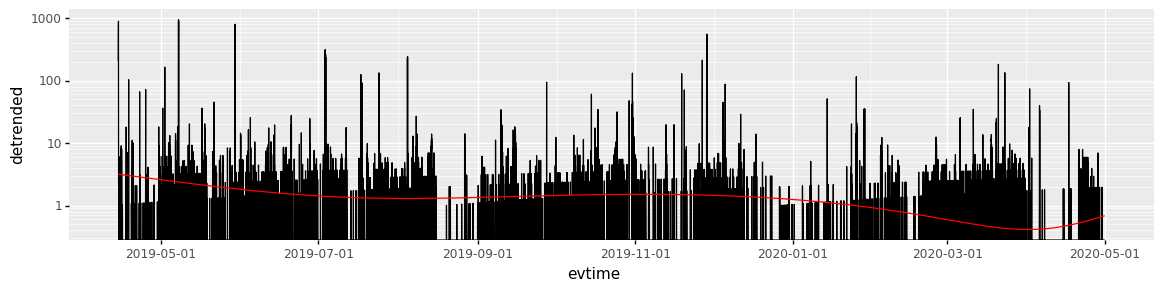

<ggplot: (340891380)>

In [123]:
# Fit seasonality
plt = ggplot(pre_covid) +\
    geom_line(aes(x='evtime', y='detrended')) +\
    geom_line(aes(x='evtime', y='seasonality'), color='red') +\
    scale_y_log10() +\
    theme(figure_size=(14, 3))

plt.save('./plots/facebook_fit_seasonality.pdf', limitsize=False)
plt

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./plots/facebook_deseasoned.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


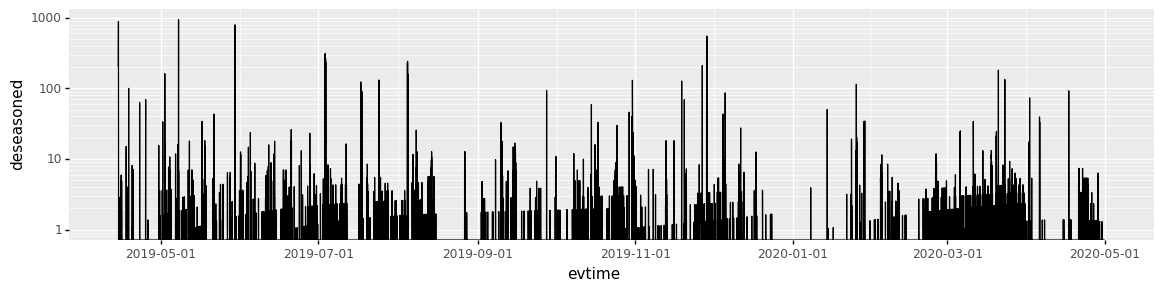

<ggplot: (347762351)>

In [127]:
# Deseasoned

plt = ggplot(pre_covid) +\
    geom_line(aes(x='evtime', y='deseasoned')) +\
    scale_y_log10() +\
    theme(figure_size=(14, 3))

plt.save('./plots/facebook_deseasoned.pdf', limitsize=False)
plt

In [170]:
def decompose_timeseries(partial_df):
    sorted_partial_df = partial_df.sort_values('event_time').reset_index(drop=True)
    
    # Compute trend
    model = LinearRegression()
    zeroed_time = (sorted_partial_df['event_time'] - sorted_partial_df.loc[0, 'event_time']).values.reshape(-1, 1)
    model.fit(zeroed_time, sorted_partial_df['status_code'].values)
    # calculate trend
    trend = model.predict(zeroed_time)
    trend[trend < 1] = 0
    sorted_partial_df['trend'] = trend
    sorted_partial_df.loc[sorted_partial_df['trend'] < 1, 'trend'] = 0
    
    sorted_partial_df['detrended'] = sorted_partial_df['status_code'] - sorted_partial_df['trend']
    sorted_partial_df.loc[sorted_partial_df['detrended'] < 1, 'detrended'] = 0
    
    # Compute seasonality
    pre_covid = sorted_partial_df[sorted_partial_df['evtime'] < '2020-05-01'].reset_index(drop=True)
    
    degree = 5
    reshaped_zeroed_time = (pre_covid['event_time'] - pre_covid.loc[0, 'event_time']).values
    coef = polyfit(reshaped_zeroed_time, pre_covid['detrended'].values, degree)
#     print('Coefficients: %s' % coef)
    # create curve
    curve = list()
    for i in range(len(reshaped_zeroed_time)):
        value = coef[-1]
        for d in range(degree):
            value += reshaped_zeroed_time[i]**(degree-d) * coef[d]
        curve.append(value)
        
    pre_covid['seasonality'] = curve
    pre_covid.loc[pre_covid['seasonality'] < 1, 'seasonality'] = 0
    pre_covid['residual'] = pre_covid['detrended'] - pre_covid['seasonality']
    pre_covid.loc[pre_covid['residual'] < 1, 'residual'] = 0
    
    return sorted_partial_df.join(pre_covid.set_index('event_time'), on='event_time', rsuffix='_pc')

decompose_timeseries(facebook_reports)

,event_time,status_code,vendor,monitor,evtime,trend,detrended,status_code_pc,vendor_pc,monitor_pc,evtime_pc,trend_pc,detrended_pc,seasonality,residual
0,1.555241e+09,210.0,facebook,Outage Report,2019-04-14 11:20:00,3.971304,206.028696,210.0,facebook,Outage Report,2019-04-14 11:20:00,3.971304,206.028696,3.167554,202.861142
1,1.555242e+09,299.0,facebook,Outage Report,2019-04-14 11:40:00,3.971197,295.028803,299.0,facebook,Outage Report,2019-04-14 11:40:00,3.971197,295.028803,3.167012,291.861790
2,1.555243e+09,813.0,facebook,Outage Report,2019-04-14 12:00:00,3.971091,809.028909,813.0,facebook,Outage Report,2019-04-14 12:00:00,3.971091,809.028909,3.166471,805.862439
3,1.555244e+09,874.0,facebook,Outage Report,2019-04-14 12:20:00,3.970984,870.029016,874.0,facebook,Outage Report,2019-04-14 12:20:00,3.970984,870.029016,3.165929,866.863087
4,1.555246e+09,891.0,facebook,Outage Report,2019-04-14 12:40:00,3.970877,887.029123,891.0,facebook,Outage Report,2019-04-14 12:40:00,3.970877,887.029123,3.165387,883.863736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48332,1.604180e+09,0.0,facebook,Outage Report,2020-10-31 21:40:00,0.000000,0.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
48333,1.604182e+09,0.0,facebook,Outage Report,2020-10-31 22:00:00,0.000000,0.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
48334,1.604183e+09,0.0,facebook,Outage Report,2020-10-31 22:20:00,0.000000,0.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
48335,1.604184e+09,0.0,facebook,Outage Report,2020-10-31 22:40:00,0.000000,0.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [171]:
timeseries_analyzed_df_list = []

for vendor in filtered_or_events['vendor_cat'].unique():
    partial_df = filtered_or_events[filtered_or_events['vendor_cat'] == vendor].reset_index(drop=True)
    timeseries_analyzed_df_list.append(decompose_timeseries(partial_df))
    
timeseries_analyzed_df = pd.concat(timeseries_analyzed_df_list)

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 15274 rows containing missing values.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 15274 rows containing missing values.


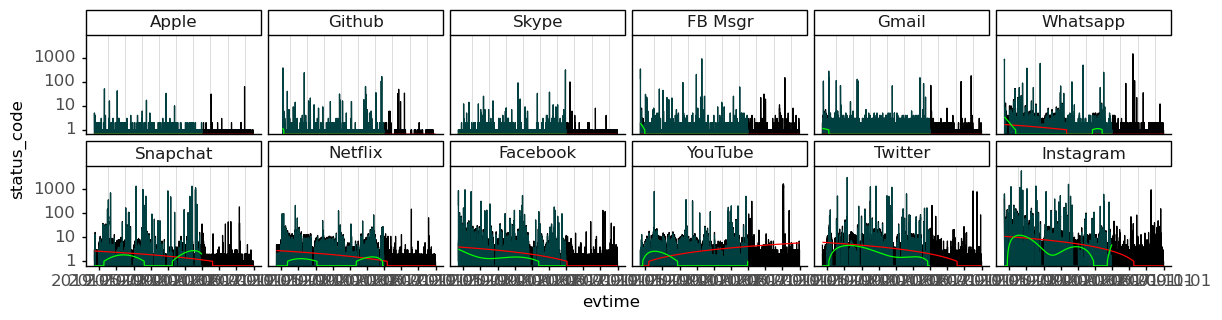

<ggplot: (421491932)>

In [175]:
plt = ggplot(timeseries_analyzed_df) +\
    geom_line(aes(x='evtime', y='status_code'), color='black') +\
    geom_line(aes(x='evtime', y='residual'), color='teal', alpha=0.5) +\
    geom_line(aes(x='evtime', y='trend'), color='red') +\
    geom_line(aes(x='evtime', y='seasonality'), color='lime') +\
    scale_y_log10() +\
    facet_wrap(facets='vendor_cat', nrow=2) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_minor_x=element_line(size=0.7, color="gainsboro"),
          panel_grid_major_x=element_blank(),
          text=element_text(size=12),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',)

plt

In [204]:
week_aggregated_df_list = []
month_aggregated_df_list = []

for vendor in filtered_or_events['vendor_cat'].unique():
    partial_df = filtered_or_events[filtered_or_events['vendor_cat'] == vendor].reset_index(drop=True)
    
    week_df = partial_df.set_index('evtime').resample('W').sum().reset_index()
    week_df['vendor_cat'] = vendor
    week_aggregated_df_list.append(week_df)
    
    month_df = partial_df.set_index('evtime').resample('M').sum().reset_index()
    month_df['vendor_cat'] = vendor
    month_aggregated_df_list.append(month_df)

week_aggregated_df = pd.concat(week_aggregated_df_list)
week_aggregated_df['vendor_cat'] = pd.Categorical(week_aggregated_df['vendor_cat'], categories=vendor_list, ordered=True)
month_aggregated_df = pd.concat(month_aggregated_df_list)
month_aggregated_df['vendor_cat'] = pd.Categorical(month_aggregated_df['vendor_cat'], categories=vendor_list, ordered=True)

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./plots/reports_week_and_month_aggregated.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


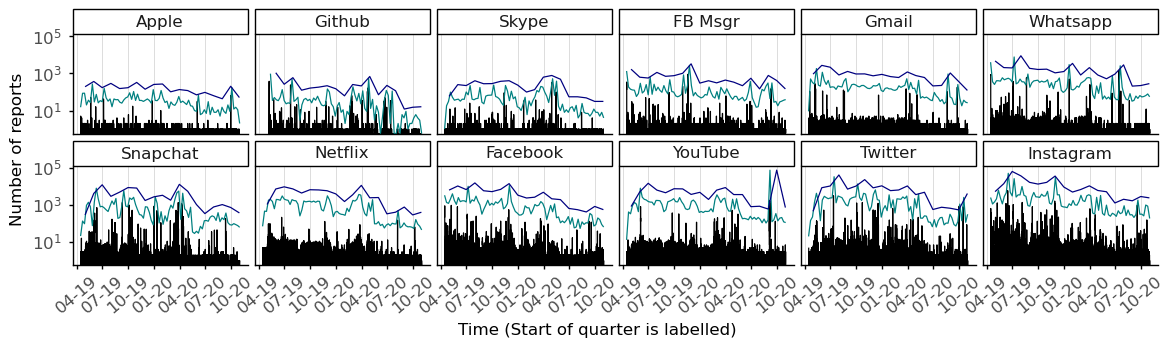

<ggplot: (397037120)>

In [217]:
plt = ggplot() +\
    geom_line(aes(x='evtime', y='status_code'), data=filtered_or_events, color='black') +\
    geom_line(aes(x='evtime', y='status_code'), data=week_aggregated_df, color='teal') +\
    geom_line(aes(x='evtime', y='status_code'), data=month_aggregated_df, color='navy') +\
    scale_y_log10(labels=lambda l: list(map(lambda x: '$10^{}$'.format(int(np.log10(x))), l))) +\
    scale_x_datetime(date_breaks='3 months', date_labels='%m-%y') +\
    facet_wrap(facets='vendor_cat', nrow=2) +\
    ylab('Number of reports') +\
    xlab('Time (Start of quarter is labelled)') +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.7, color="gainsboro"),
          text=element_text(size=12),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',
          axis_text_x=element_text(rotation=40))

plt.save('./plots/reports_week_and_month_aggregated.pdf', limitsize=None)
plt

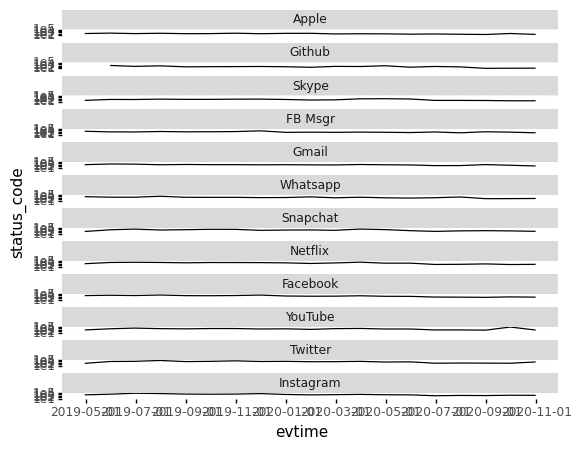

<ggplot: (333651035)>

In [216]:
plt = ggplot() +\
    geom_line(aes(x='evtime', y='status_code'), data=month_aggregated_df) +\
    scale_y_log10() +\
    facet_wrap(facets='vendor_cat', ncol=1)

plt